In [1]:
%reload_ext autoreload
%autoreload 2

from collections import Counter
import numpy as np
import pandas as pd
from app import Preprocessing

from matplotlib import pyplot as plt
import torch
import torch.nn as nn

dtype = torch.float
device = torch.device("cpu")

In [2]:
pre = Preprocessing('IMDB')

In [13]:
pre.load_data(name='IMDB')

In [14]:
pre.data['test_raw'].head()

,text,POS__NEG
0,"I couldn't stop watching this movie, though it...",1
1,This is a silly spoof of private eye thrillers...,0
2,I saw Riverdance - The New Show and loved it f...,1
3,EXCUSE ME!!! HellOOOOOOOOOO!!!!!!!!!!! CUBA GO...,1
4,"For me, Pink Flamingos lived up to it's reputa...",1


In [5]:
# Create three Counter objects to store positive, negative and total counts
positive_counts = Counter()
negative_counts = Counter()
total_counts = Counter()
pos_neg_ratios = Counter()

In [6]:
# Loop over all the words in all the reviews and increment the counts in the appropriate counter objects
for i in range(pre.data['Train'].shape[0]):
    if(pre.data['Train']['POS__NEG'][i] == 1):
        for word in pre.data['Train']['text'][i].split(" "):
            positive_counts[word] += 1
            total_counts[word] += 1
    else:
        for word in pre.data['Train']['text'][i].split(" "):
            negative_counts[word] += 1
            total_counts[word] += 1

In [7]:
pos_neg_ratios = Counter()

# Calculate the ratios of positive and negative uses of the most common words
# Consider words to be "common" if they've been used at least 100 times
for term,cnt in list(total_counts.most_common()):
    if(cnt > 100):
        pos_neg_ratio = positive_counts[term] / float(negative_counts[term]+1)
        pos_neg_ratios[term] = pos_neg_ratio

In [8]:
drop_count=0
drop_words = []

# Convert ratios to logs
for word,ratio in pos_neg_ratios.most_common():
    pos_neg_ratios[word] = np.log(ratio)
    if pos_neg_ratios[word]>-0.95 and pos_neg_ratios[word]<0.95:
        drop_words.append(word)
        drop_count+=1

In [9]:
len(list(drop_words))

3935

In [10]:
len(list(pos_neg_ratios))

4328

In [11]:
listx = pos_neg_ratios.copy()

In [12]:
for dword in drop_words:
    del listx[dword]

In [13]:
len(list(listx))

393

In [14]:
word_list = dict(listx)

In [15]:
count = 0
for key,idx in word_list.items():
    word_list[key]=count
    count+=1

In [16]:
data=np.zeros((pre.data['Train'].shape[0], len(word_list)))

for i in range(pre.data['Train'].shape[0]):    
     for word in pre.data['Train']['text'][i].split(" "):
            if word in word_list:
                data[i][word_list[word]]+=word_list[word]



In [17]:
data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 2., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [18]:
data.shape

(25000, 393)

In [19]:
pre.set('Train_raw', pre.data['Train'])

In [20]:
pre.set('Train', pd.DataFrame(data, columns=word_list))

In [21]:
x = torch.tensor(pre.data['Train'][:2000].values).float()
y = torch.tensor(pre.get('Train_raw')['POS__NEG'].values).float()

In [29]:
# Logistic regression model
model = torch.nn.Sequential(
    torch.nn.Linear(x.shape[1], y.shape[0]),
    torch.nn.Sigmoid()
)

In [30]:
# Hyper-parameters 
learning_rate = 10

In [31]:
# Loss and optimizer
# nn.CrossEntropyLoss() computes softmax internally

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [32]:
loss_hist = []
# Train
for t in range(1000):
    # Berechne die Vorhersage (foward step)
    outputs = model(x)
    
    # Berechne den Fehler (Ausgabe des Fehlers alle 50 Iterationen)
    loss = criterion(outputs, y)
    
    # Berechne die Gradienten und Aktualisiere die Gewichte (backward step)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Berechne den Fehler (Ausgabe des Fehlers alle 100 Iterationen)
    if t % 20 == 0:
        loss_hist.append(loss.item())
        print(t, loss.item())

0 0.4161137044429779
20 0.40750208497047424
40 0.3993304669857025
60 0.3916178345680237
80 0.3843362629413605
100 0.3774321377277374
120 0.37085801362991333
140 0.36457255482673645
160 0.35854336619377136
180 0.35274240374565125
200 0.3471488952636719
220 0.3417413830757141
240 0.33650287985801697
260 0.33141928911209106
280 0.32647740840911865
300 0.3216659128665924
320 0.31697791814804077
340 0.31240609288215637
360 0.3079439103603363
380 0.3035847842693329
400 0.29932406544685364
420 0.29515767097473145
440 0.2910784184932709
460 0.28708499670028687
480 0.28317445516586304
500 0.2793439030647278
520 0.27559003233909607
540 0.2719096839427948
560 0.26829904317855835
580 0.2647560238838196
600 0.26127707958221436
620 0.2578592002391815
640 0.2545022964477539
660 0.251203715801239
680 0.2479640245437622
700 0.24478338658809662
720 0.24165832996368408
740 0.23858533799648285
760 0.2355635017156601
780 0.23259344696998596
800 0.2296728789806366
820 0.2268015742301941
840 0.22397893667221

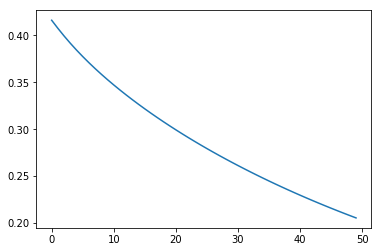

In [33]:
plt.plot(loss_hist);

# Forest classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [34]:
error_train = []
error_val = []
auc_val = []
auc_train = []

for i in range(1, 6):
    #for j in range(1,5):
        #for k in range(2,10):
    d_forest = RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=i,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight=None,
    )
    d_forest.fit(x, y)
    y_pred_prob_train = d_forest.predict_proba(x)
#    y_pred_prob_val = d_forest.predict_proba(X_val)
    error_train.append(metrics.mean_squared_error(y, y_pred_prob_train[:,1]))
#    error_val.append(metrics.mean_squared_error(y_val, y_pred_prob_val[:,1]))

    fpr, tpr, thresholds = metrics.roc_curve(y, y_pred_prob_train[:,1])
    auc_train.append(metrics.auc(fpr, tpr))

#    fpr, tpr, thresholds = metrics.roc_curve(y_val, y_pred_prob_val[:,1])
#    auc_val.append(metrics.auc(fpr, tpr))

NameError: name 'RandomForestClassifier' is not defined